In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import os, json, math, librosa

import IPython.display as ipd
import librosa.display

import tensorflow as tf
import tensorflow.keras as keras

from tensorflow.keras import Sequential
from tensorflow.keras.layers import Conv2D

import sklearn.model_selection as sk

from sklearn.model_selection import train_test_split

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
%ls

drive/  sample_data/


In [4]:
# Getting Genres from folder name

MUSIC = '/content/drive/MyDrive/Data/genres/'
music_dataset = [] # File locations for each wav file 
genre_target = [] # 
for root, dirs, files in os.walk(MUSIC):
  print(root)
  for name in files:
    filename = os.path.join(root, name)
    if filename != '/data/genres/jazz/jazz.00054.wav':
      music_dataset.append(filename)
      genre_target.append(filename.split("/")[-2])
            

/content/drive/MyDrive/Data/genres/
/content/drive/MyDrive/Data/genres/disco
/content/drive/MyDrive/Data/genres/pop
/content/drive/MyDrive/Data/genres/country
/content/drive/MyDrive/Data/genres/jazz
/content/drive/MyDrive/Data/genres/blues
/content/drive/MyDrive/Data/genres/metal
/content/drive/MyDrive/Data/genres/rock
/content/drive/MyDrive/Data/genres/hiphop
/content/drive/MyDrive/Data/genres/reggae
/content/drive/MyDrive/Data/genres/classical


In [5]:
# Displaying genres 

print(set(genre_target))

{'metal', 'jazz', 'reggae', 'disco', 'country', 'classical', 'blues', 'rock', 'hiphop', 'pop'}


In [6]:
# Testing Audio Files

audio_path = music_dataset[500]
# img_path = './data/images_original/blues/blues00011.png'

x , sr = librosa.load(audio_path)



librosa.load(audio_path, sr=None)

ipd.Audio(audio_path)



In [7]:
DATASET_PATH = '/content/drive/MyDrive/Data/genres/'
JSON_PATH = "data_10.json"
SAMPLE_RATE = 22050
TRACK_DURATION = 30 # measured in seconds
SAMPLES_PER_TRACK = SAMPLE_RATE * TRACK_DURATION


def save_mfcc(dataset_path, json_path, num_mfcc=13, n_fft=2048, hop_length=512, num_segments=5):
   

    # dictionary to store mapping, labels, and MFCCs
    data = {
        "mapping": [],
        "labels": [],
        "mfcc": []
    }

    samples_per_segment = int(SAMPLES_PER_TRACK / num_segments)
    num_mfcc_vectors_per_segment = math.ceil(samples_per_segment / hop_length)

    # loop through all genre sub-folder
    for i, (dirpath, dirnames, filenames) in enumerate(os.walk(dataset_path)):

        # ensure we're processing a genre sub-folder level
        if dirpath is not dataset_path:

            # save genre label (i.e., sub-folder name) in the mapping
            semantic_label = dirpath.split("/")[-1]
            data["mapping"].append(semantic_label)
            print("\nProcessing: {}".format(semantic_label))

            # process all audio files in genre sub-dir
            for f in filenames:

		# load audio file

                file_path = os.path.join(dirpath, f)
            
                if file_path != '/content/drive/MyDrive/Data/genres/jazz/jazz.00054.wav':

                    signal, sample_rate = librosa.load(file_path, sr=SAMPLE_RATE)
                
                
                    # process all segments of audio file
                    for d in range(num_segments):

                        # calculate start and finish sample for current segment
                        start = samples_per_segment * d
                        finish = start + samples_per_segment

                        # extract mfcc
                        mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
                        mfcc = mfcc.T

                        # store only mfcc feature with expected number of vectors
                        if len(mfcc) == num_mfcc_vectors_per_segment:
                            data["mfcc"].append(mfcc.tolist())
                            data["labels"].append(i-1)
                            print("{}, segment:{}".format(file_path, d+1))

    # save MFCCs to json file
    with open(json_path, "w") as fp:
        json.dump(data, fp, indent=4)

In [8]:
# Runs Data Processing     
save_mfcc(DATASET_PATH, JSON_PATH, num_segments=6)

Streaming output truncated to the last 5000 lines.
/content/drive/MyDrive/Data/genres/pop/pop.00075.wav, segment:1
/content/drive/MyDrive/Data/genres/pop/pop.00075.wav, segment:2
/content/drive/MyDrive/Data/genres/pop/pop.00075.wav, segment:3
/content/drive/MyDrive/Data/genres/pop/pop.00075.wav, segment:4
/content/drive/MyDrive/Data/genres/pop/pop.00075.wav, segment:5
/content/drive/MyDrive/Data/genres/pop/pop.00075.wav, segment:6
/content/drive/MyDrive/Data/genres/pop/pop.00074.wav, segment:1
/content/drive/MyDrive/Data/genres/pop/pop.00074.wav, segment:2
/content/drive/MyDrive/Data/genres/pop/pop.00074.wav, segment:3
/content/drive/MyDrive/Data/genres/pop/pop.00074.wav, segment:4
/content/drive/MyDrive/Data/genres/pop/pop.00074.wav, segment:5
/content/drive/MyDrive/Data/genres/pop/pop.00074.wav, segment:6
/content/drive/MyDrive/Data/genres/pop/pop.00066.wav, segment:1
/content/drive/MyDrive/Data/genres/pop/pop.00066.wav, segment:2
/content/drive/MyDrive/Data/genres/pop/pop.00066.wav,

In [9]:

DATA_PATH = "data_10.json"


def load_data(data_path):
    

    with open(data_path, "r") as fp:
        data = json.load(fp)

    X = np.array(data["mfcc"])
    y = np.array(data["labels"])
    z = np.array(data['mapping'])
    return X, y, z


def plot_history(history):
    

    fig, axs = plt.subplots(2)

    # create accuracy sublpot
    axs[0].plot(history.history["accuracy"], label="train accuracy")
    axs[0].plot(history.history["val_accuracy"], label="test accuracy")
    axs[0].set_ylabel("Accuracy")
    axs[0].legend(loc="lower right")
    axs[0].set_title("Accuracy eval")

    # create error sublpot
    axs[1].plot(history.history["loss"], label="train error")
    axs[1].plot(history.history["val_loss"], label="test error")
    axs[1].set_ylabel("Error")
    axs[1].set_xlabel("Epoch")
    axs[1].legend(loc="upper right")
    axs[1].set_title("Error eval")

    plt.show()


def prepare_datasets(test_size, validation_size):

    # load data
    X, y, z = load_data(DATA_PATH)

    # create train, validation and test split
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size)
    X_train, X_validation, y_train, y_validation = train_test_split(X_train, y_train, test_size=validation_size)

    # add an axis to input sets
    X_train = X_train[..., np.newaxis]
    X_validation = X_validation[..., np.newaxis]
    X_test = X_test[..., np.newaxis]

    return X_train, X_validation, X_test, y_train, y_validation, y_test, z


def build_model(input_shape):
    

    # build network topology
    model = keras.Sequential()

    # 1st conv layer
    model.add(keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=input_shape))
    model.add(keras.layers.MaxPooling2D((3, 3), strides=(2, 2), padding='same'))
    model.add(keras.layers.BatchNormalization())

    # 2nd conv layer
    model.add(keras.layers.Conv2D(32, (3, 3), activation='relu'))
    model.add(keras.layers.MaxPooling2D((3, 3), strides=(2, 2), padding='same'))
    model.add(keras.layers.BatchNormalization())

    # 3rd conv layer
    model.add(keras.layers.Conv2D(32, (2, 2), activation='relu'))
    model.add(keras.layers.MaxPooling2D((2, 2), strides=(2, 2), padding='same'))
    model.add(keras.layers.BatchNormalization())

    # flatten output and feed it into dense layer
    model.add(keras.layers.Flatten())
    model.add(keras.layers.Dense(64, activation='relu'))
    model.add(keras.layers.Dropout(0.3))

    # output layer
    model.add(keras.layers.Dense(10, activation='softmax'))

    return model







Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_15 (Conv2D)           (None, 214, 11, 32)       320       
_________________________________________________________________
max_pooling2d_15 (MaxPooling (None, 107, 6, 32)        0         
_________________________________________________________________
batch_normalization_15 (Batc (None, 107, 6, 32)        128       
_________________________________________________________________
conv2d_16 (Conv2D)           (None, 105, 4, 32)        9248      
_________________________________________________________________
max_pooling2d_16 (MaxPooling (None, 53, 2, 32)         0         
_________________________________________________________________
batch_normalization_16 (Batc (None, 53, 2, 32)         128       
_________________________________________________________________
conv2d_17 (Conv2D)           (None, 52, 1, 32)        

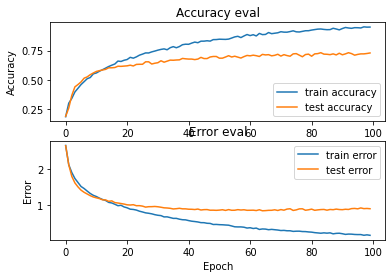

47/47 - 0s - loss: 0.8809 - accuracy: 0.7270

Test accuracy: 0.726969301700592


In [19]:
# get train, validation, test splits
X_train, X_validation, X_test, y_train, y_validation, y_test, z = prepare_datasets(0.25, 0.2)

# create network
input_shape = (X_train.shape[1], X_train.shape[2], 1)
model = build_model(input_shape)

# compile model
optimiser = keras.optimizers.Adam(learning_rate=0.0001)
model.compile(optimizer=optimiser,
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

model.summary()

# train model
history = model.fit(X_train, y_train, validation_data=(X_validation, y_validation), batch_size=64, epochs=100)

# plot accuracy/error for training and validation
plot_history(history)

# evaluate model on test set
test_loss, test_acc = model.evaluate(X_test, y_test, verbose=2)
print('\nTest accuracy:', test_acc)

# model.save('model.h5')


In [11]:
def predict(model, X, y):
    X = X[np.newaxis, ...] # array shape (1, 130, 13, 1)
    prediction = model.predict(X)
    predicted_index = np.argmax(prediction, axis=1)
    target = z[y]
    predicted = z[predicted_index]

    print("Target: {}, Predicted label: {}".format(target, predicted))

X_to_predict = X_test[103]
y_to_predict = y_test[103]

predict(model, X_to_predict, y_to_predict)

Target: classical, Predicted label: ['classical']
